In [13]:
cd ..

/Users/hyunminhong


In [14]:
from src.Utility import Utility, MeasurementType
from src.KalmanFilterSV_new import HestonKalmanFilter
from src.KalmanFilterCorr_new import HestonKalmanFilterCorr
from src.Heston import *
from filtering.filtering import particle_filter as pf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
# Set initial conditions and simulation parameters
S0 = 100
V0 = 0.04
params = {
    'mu': 0.05,
    'rho': -0.8,
    'kappa': 5.0,
    'theta': 0.04,
    'xi': 0.5
}
std_asy = np.sqrt(params['theta'] * params['xi']**2 / (2 * params['kappa']))
assert 2 * params['kappa'] * params['theta'] > params['xi']**2, "Feller condition is violated!"

Hest = Heston(**params)
time_daily, S_daily, daily_returns, daily_true_V, daily_RV = Hest.path_simulation(
    S0, V0, T_years=10, trading_days=252, intraday_intervals=39, seed=40
)
R_daily = daily_returns.copy()

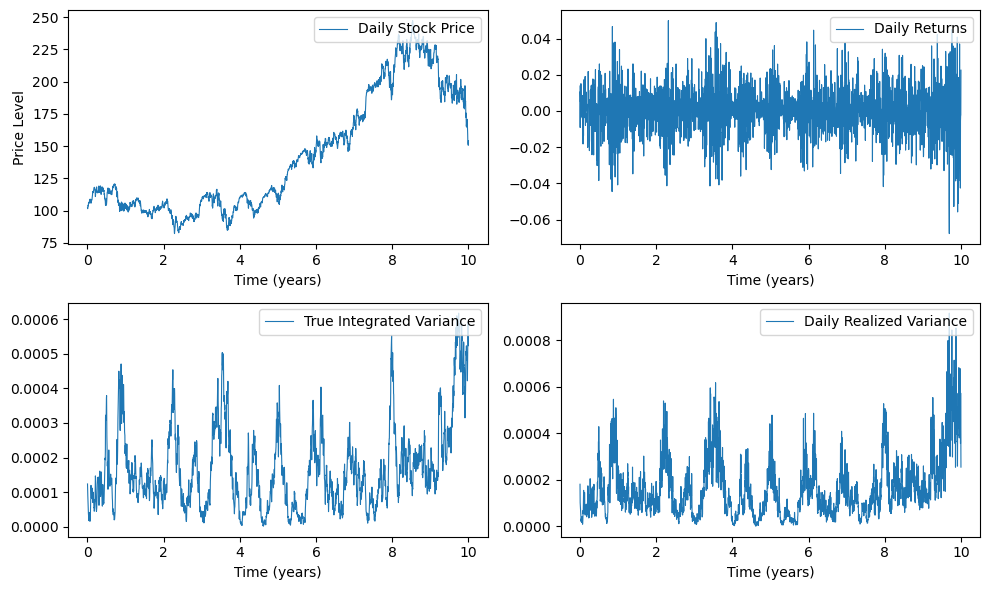

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

# Subplot for BOTH measurements
axes[0,0].plot(time_daily, S_daily, label="Daily Stock Price", lw=0.8)
axes[0,0].set_xlabel("Time (years)")
axes[0,0].set_ylabel("Price Level")
axes[0,0].legend(loc="upper right")

# Subplot for RETURNS measurement
axes[0,1].plot(time_daily, daily_returns, label="Daily Returns", lw=0.8)
axes[0,1].set_xlabel("Time (years)")
axes[0,1].legend(loc="upper right")

# Subplot for RV measurement
axes[1,0].plot(time_daily, daily_true_V, label="True Integrated Variance", lw=0.8)
axes[1,0].set_xlabel("Time (years)")
axes[1,0].legend(loc="upper right")

# Subplot for RV measurement
axes[1,1].plot(time_daily, daily_RV, label="Daily Realized Variance", lw=0.8)
axes[1,1].set_xlabel("Time (years)")
axes[1,1].legend(loc="upper right")

plt.tight_layout()
plt.show()

In [17]:
burnin = 252
dt = 1  # Daily

split_index = 6 * 252 

# TRAINING SET 
train_returns = daily_returns[:split_index]
train_RV = daily_RV[:split_index]

# TEST SET 
test_returns = daily_returns[split_index:]
test_RV = daily_RV[split_index:]

### Both

In [18]:
# Fit the model using training data
hkf_both = HestonKalmanFilter(measurement_type=MeasurementType.BOTH, dt=dt, V0=0.01, P0=0.1)
hkf_both.set_data(returns=train_returns, rv=train_RV)
initial_params_both = np.array([0.001, 0.001, 0.001, 0.001, 0.001])

fit_results_both = hkf_both.fit(initial_params=initial_params_both, burnin=burnin)
params_opt_both = fit_results_both['params']
print("Optimized parameters (BOTH):", params_opt_both)

train_result_both = hkf_both.filter(params_opt_both)
last_V_train = train_result_both['V_filt'][-1]
last_P_train = train_result_both['P_filt'][-1]

hkf_both_test = HestonKalmanFilter(measurement_type=MeasurementType.BOTH, dt=dt, V0=last_V_train, P0=last_P_train)
V_filt_both_test = hkf_both_test.filter(params=params_opt_both, returns=test_returns, rv=test_RV)['V_filt']

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.41066D+04    |proj g|=  5.82880D+04

At iterate    1    f= -1.41163D+04    |proj g|=  2.01000D-01

At iterate    2    f= -1.41194D+04    |proj g|=  2.00935D-01

At iterate    3    f= -1.41264D+04    |proj g|=  1.01074D+04

At iterate    4    f= -1.41271D+04    |proj g|=  1.71654D+03

At iterate    5    f= -1.41271D+04    |proj g|=  2.07490D+02

At iterate    6    f= -1.41271D+04    |proj g|=  2.28805D+02

At iterate    7    f= -1.41271D+04    |proj g|=  3.48238D+02

At iterate    8    f= -1.41271D+04    |proj g|=  4.47198D+02

At iterate    9    f= -1.41272D+04    |proj g|=  7.60802D+02

At iterate   10    f= -1.41272D+04    |proj g|=  9.36092D+02

At iterate   11    f= -1.41273D+04    |proj g|=  1.55847D+03

At iterate   12    f= -1.41276D+04    |proj g|=  2.16240D+03

At iterate   13    f= -1.4

### Both - Corr

In [19]:
hkf_both_corr = HestonKalmanFilterCorr(measurement_type=MeasurementType.BOTH, dt=dt, V0=0.01, P0=0.1)
hkf_both_corr.set_data(returns=train_returns, rv=train_RV)
initial_params_both_corr = np.array([0.015, 0.0001, 0.001, 0.001, 0.001, -0.1])

fit_results_both = hkf_both_corr.fit(initial_params=initial_params_both_corr, burnin=burnin)
params_opt_both = fit_results_both['params']
print("Optimized parameters (BOTH):", params_opt_both)

train_result_both_corr = hkf_both_corr.filter(params_opt_both)
last_V_train_corr = train_result_both_corr['V_filt'][-1]
last_P_train_corr = train_result_both_corr['P_filt'][-1]

hkf_both_test_corr = HestonKalmanFilterCorr(measurement_type=MeasurementType.BOTH, dt=dt, V0=last_V_train_corr, P0=last_P_train_corr)
V_filt_both_test_corr = hkf_both_test_corr.filter(params=params_opt_both, returns=test_returns, rv=test_RV)['V_filt']

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.41250D+04    |proj g|=  4.92151D+04

At iterate    1    f= -1.41315D+04    |proj g|=  8.95709D+02

At iterate    2    f= -1.41333D+04    |proj g|=  8.90000D-01

At iterate    3    f= -1.41335D+04    |proj g|=  2.58716D+03

At iterate    4    f= -1.41342D+04    |proj g|=  9.42377D+03

At iterate    5    f= -1.41360D+04    |proj g|=  1.76061D+04

At iterate    6    f= -1.41393D+04    |proj g|=  1.51117D+04

At iterate    7    f= -1.41401D+04    |proj g|=  1.74490D+03

At iterate    8    f= -1.41401D+04    |proj g|=  1.99972D+00

At iterate    9    f= -1.41401D+04    |proj g|=  1.99972D+00

At iterate   10    f= -1.41401D+04    |proj g|=  1.99972D+00

At iterate   11    f= -1.41401D+04    |proj g|=  8.89980D-01

At iterate   12    f= -1.41401D+04    |proj g|=  8.89975D-01

At iterate   13    f= -1.4

/Users/hyunminhong/anaconda3/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0



QMLE Results for Heston Model:
At iterate   47    f= -1.41540D+04    |proj g|=  7.95260D+04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     47     60     51     0     0   7.953D+04  -1.415D+04
  F =  -14154.047891370112     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

--------------------------------------------------
kappa: 0.026153
theta: 0.000086
xi: 0.001269
mu: -0.000162
sigma: 0.000520
rho: -0.301034
Negative Log-Likelihood: -14154.047891
Convergence: True
--------------------------------------------------
Optimized parameters (BOTH): [ 2.61531086e-02  8.58355260e-05  1.26900926e-03 -1

### Return

In [20]:
# Fit the model using training data
hkf_returns = HestonKalmanFilter(measurement_type=MeasurementType.RETURNS, dt=dt, V0=0.01, P0=0.1)
hkf_returns.set_data(returns=train_returns)
initial_params_returns = np.array([0.001, 0.001, 0.001, 0.001])

fit_results_returns = hkf_returns.fit(initial_params=initial_params_returns, burnin=burnin)
params_opt_returns = fit_results_returns['params']
print("Optimized parameters (RETURNS):", params_opt_returns)

train_result_returns = hkf_returns.filter(params_opt_returns)
last_V_returns = train_result_returns['V_filt'][-1]
last_P_returns = train_result_returns['P_filt'][-1]

hkf_returns_test = HestonKalmanFilter(measurement_type=MeasurementType.RETURNS, dt=dt, V0=last_V_returns, P0=last_P_returns)
V_filt_returns_test = hkf_returns_test.filter(params=params_opt_returns, returns=test_returns)['V_filt']

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.84558D+03    |proj g|=  4.44007D+05

At iterate    1    f= -3.10315D+03    |proj g|=  6.80373D+01

At iterate    2    f= -3.11508D+03    |proj g|=  9.87312D-01

At iterate    3    f= -3.12339D+03    |proj g|=  9.87330D-01

At iterate    4    f= -3.17064D+03    |proj g|=  7.76634D+05

At iterate    5    f= -3.17503D+03    |proj g|=  9.85526D-01

At iterate    6    f= -3.17734D+03    |proj g|=  9.83343D-01

At iterate    7    f= -3.18850D+03    |proj g|=  6.34945D+05

At iterate    8    f= -3.19988D+03    |proj g|=  3.70841D+06

At iterate    9    f= -3.20891D+03    |proj g|=  3.00880D+06

At iterate   10    f= -3.22465D+03    |proj g|=  3.00013D+06

At iterate   11    f= -3.26219D+03    |proj g|=  4.10053D+06

At iterate   12    f= -3.27478D+03    |proj g|=  6.83262D+05

At iterate   13    f= -3.2


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   52    f= -3.86870D+03    |proj g|=  2.03960D+02

QMLE Results for Heston Model:
At iterate   53    f= -3.86870D+03    |proj g|=  2.03960D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     53    175     61     0     0   2.040D+02  -3.869D+03
  F =  -3868.6991322218641     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

--------------------------------------------------
kappa: 0.019636
theta: 0.000191
xi: 0.007903
mu: -0.000969
Negative Log-Likelihood: -3868.699132
Convergence: True
--------------------------------------------------
Optimized parameters (RETURNS): [ 0.01963627  0.00


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


### Return - Corr

In [21]:
# Fit the model using training data
hkf_returns_corr = HestonKalmanFilterCorr(measurement_type=MeasurementType.RETURNS, dt=dt, V0=0.02, P0=0.1)
hkf_returns_corr.set_data(returns=train_returns)
initial_params_returns_corr = np.array([0.002, 0.0001, 0.007, 0.002, 0])

fit_results_returns = hkf_returns_corr.fit(initial_params=initial_params_returns_corr, burnin=burnin)
params_opt_returns = fit_results_returns['params']
print("Optimized parameters (RETURNS):", params_opt_returns)

train_result_returns_corr = hkf_returns_corr.filter(params_opt_returns)
last_V_returns_corr = train_result_returns_corr['V_filt'][-1]
last_P_returns_corr = train_result_returns_corr['P_filt'][-1]

hkf_returns_test_corr = HestonKalmanFilterCorr(measurement_type=MeasurementType.RETURNS, dt=dt, V0=last_V_returns_corr, P0=last_P_returns_corr)
V_filt_returns_test_corr = hkf_returns_test_corr.filter(params=params_opt_returns, returns=test_returns)['V_filt']

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.44426D+03    |proj g|=  1.94691D+05

At iterate    1    f= -3.62594D+03    |proj g|=  1.12574D+07

At iterate    2    f= -3.66749D+03    |proj g|=  1.25374D+00

At iterate    3    f= -3.73766D+03    |proj g|=  1.00325D+00

At iterate    4    f= -3.75523D+03    |proj g|=  3.68106D+05

At iterate    5    f= -3.75621D+03    |proj g|=  9.99519D-01

At iterate    6    f= -3.75693D+03    |proj g|=  9.98758D-01

At iterate    7    f= -3.75697D+03    |proj g|=  1.23334D+04

At iterate    8    f= -3.75701D+03    |proj g|=  2.58275D+04

At iterate    9    f= -3.75732D+03    |proj g|=  1.04943D+05

At iterate   10    f= -3.75790D+03    |proj g|=  1.91545D+05

At iterate   11    f= -3.75942D+03    |proj g|=  3.28422D+05

At iterate   12    f= -3.76225D+03    |proj g|=  4.38729D+05

At iterate   13    f= -3.7


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


### RV

In [22]:
hkf_rv = HestonKalmanFilter(measurement_type=MeasurementType.RV, dt=dt, V0=0.01, P0=0.1)
hkf_rv.set_data(rv=train_RV)
initial_params_rv = np.array([0.001, 0.001, 0.001, 0.001])

fit_results_rv = hkf_rv.fit(initial_params=initial_params_rv, burnin=burnin)
params_opt_rv = fit_results_rv['params']
print("Optimized parameters (RV):", params_opt_rv)

train_result_rv = hkf_rv.filter(params_opt_rv)
last_V_rv = train_result_rv['V_filt'][-1]
last_P_rv = train_result_rv['P_filt'][-1]

hkf_rv_test = HestonKalmanFilter(measurement_type=MeasurementType.RV, dt=dt, V0=last_V_rv, P0=last_P_rv)
V_filt_rv_test = hkf_rv_test.filter(params=params_opt_returns, rv=test_RV)['V_filt']

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.06152D+03    |proj g|=  2.38198D+06

At iterate    1    f= -1.00447D+04    |proj g|=  4.09865D+02

At iterate    2    f= -1.09216D+04    |proj g|=  3.78601D-03

At iterate    3    f= -1.09631D+04    |proj g|=  1.36130D+03

At iterate    4    f= -1.09926D+04    |proj g|=  3.08464D-03

At iterate    5    f= -1.09994D+04    |proj g|=  4.18747D+03

At iterate    6    f= -1.09999D+04    |proj g|=  6.53952D+02

At iterate    7    f= -1.09999D+04    |proj g|=  5.78421D+02

At iterate    8    f= -1.09999D+04    |proj g|=  4.50607D+02

At iterate    9    f= -1.10000D+04    |proj g|=  2.05368D+02

At iterate   10    f= -1.10000D+04    |proj g|=  7.40290D+01

At iterate   11    f= -1.10000D+04    |proj g|=  8.35516D+01

At iterate   12    f= -1.10000D+04    |proj g|=  8.91383D+01

At iterate   13    f= -1.1

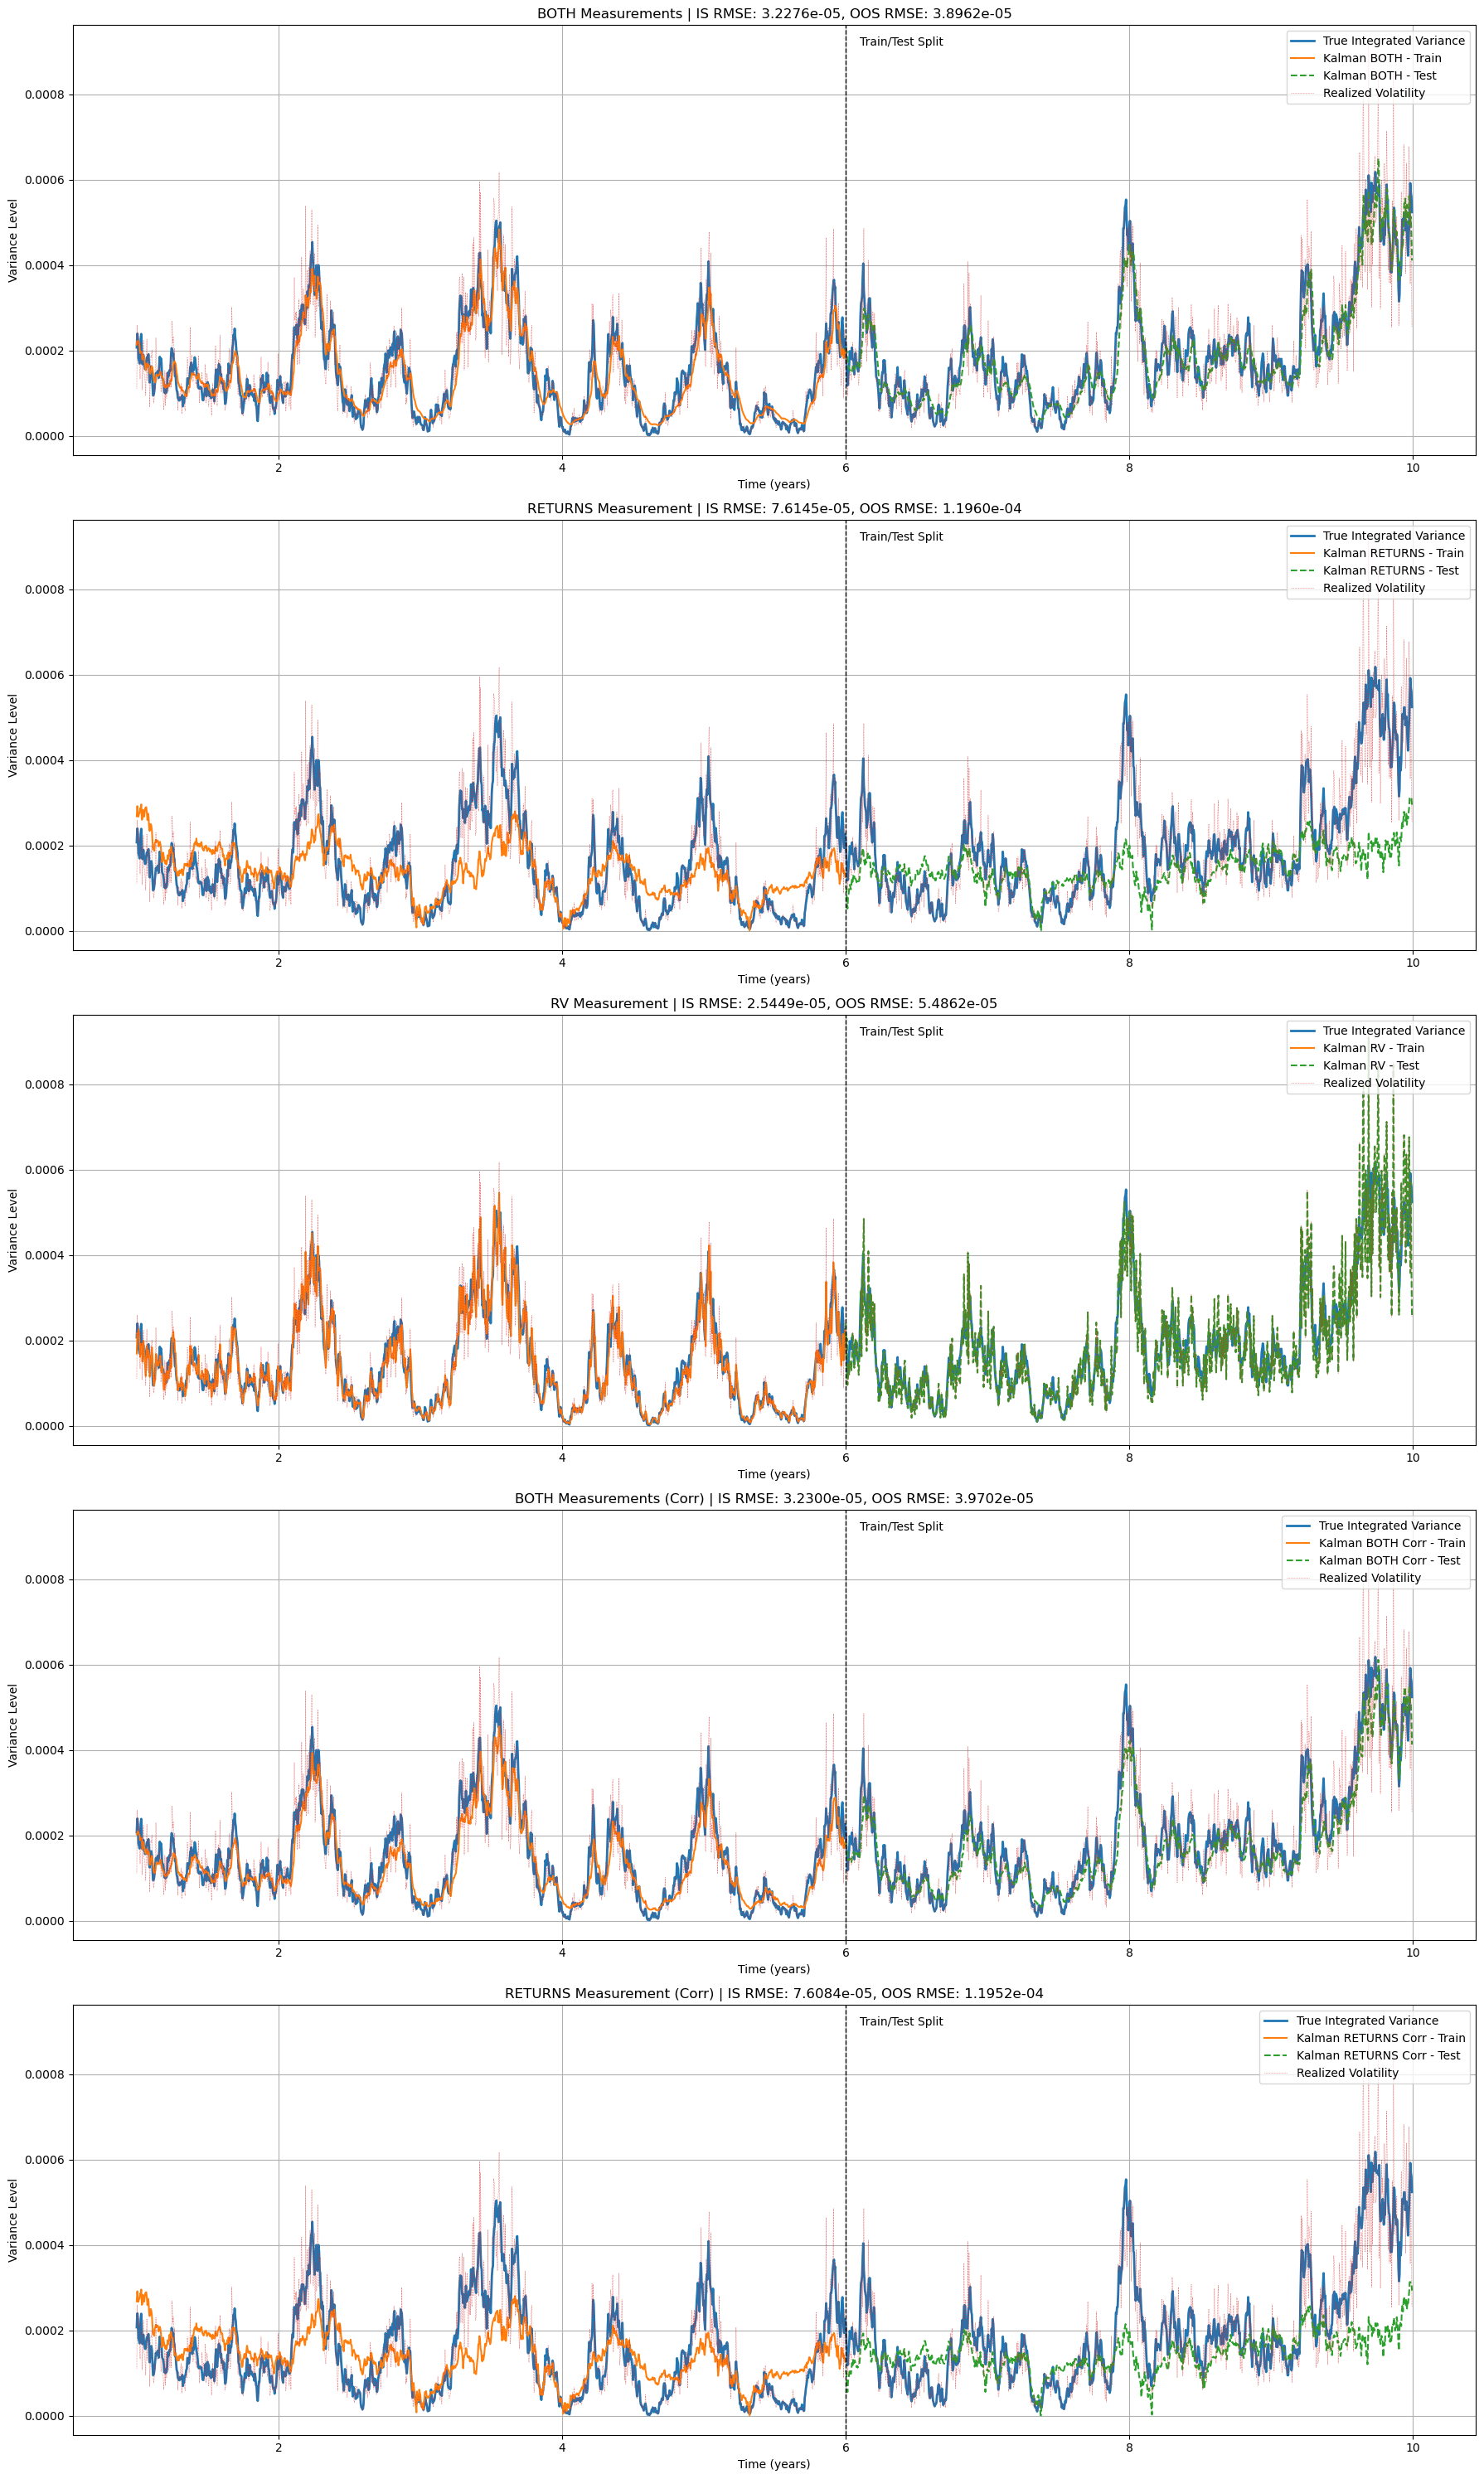

In [23]:
titles_all = ["BOTH Measurements", "RETURNS Measurement", "RV Measurement", "BOTH Measurements (Corr)", "RETURNS Measurement (Corr)"]
labels_all = ["Kalman BOTH", "Kalman RETURNS", "Kalman RV", "Kalman BOTH Corr", "Kalman RETURNS Corr"]
train_all = [train_result_both['V_filt'], train_result_returns['V_filt'], train_result_rv['V_filt'], train_result_both_corr['V_filt'], train_result_returns_corr['V_filt']]
test_all = [V_filt_both_test, V_filt_returns_test, V_filt_rv_test, V_filt_both_test_corr, V_filt_returns_test_corr]

Utility.plot_all_filters(
    titles=titles_all,
    labels=labels_all,
    train_filtered_list=train_all,
    test_filtered_list=test_all,
    daily_true_V=daily_true_V,
    daily_RV=daily_RV,
    daily_returns=daily_returns,
    split_index=split_index,
    burnin=252
)

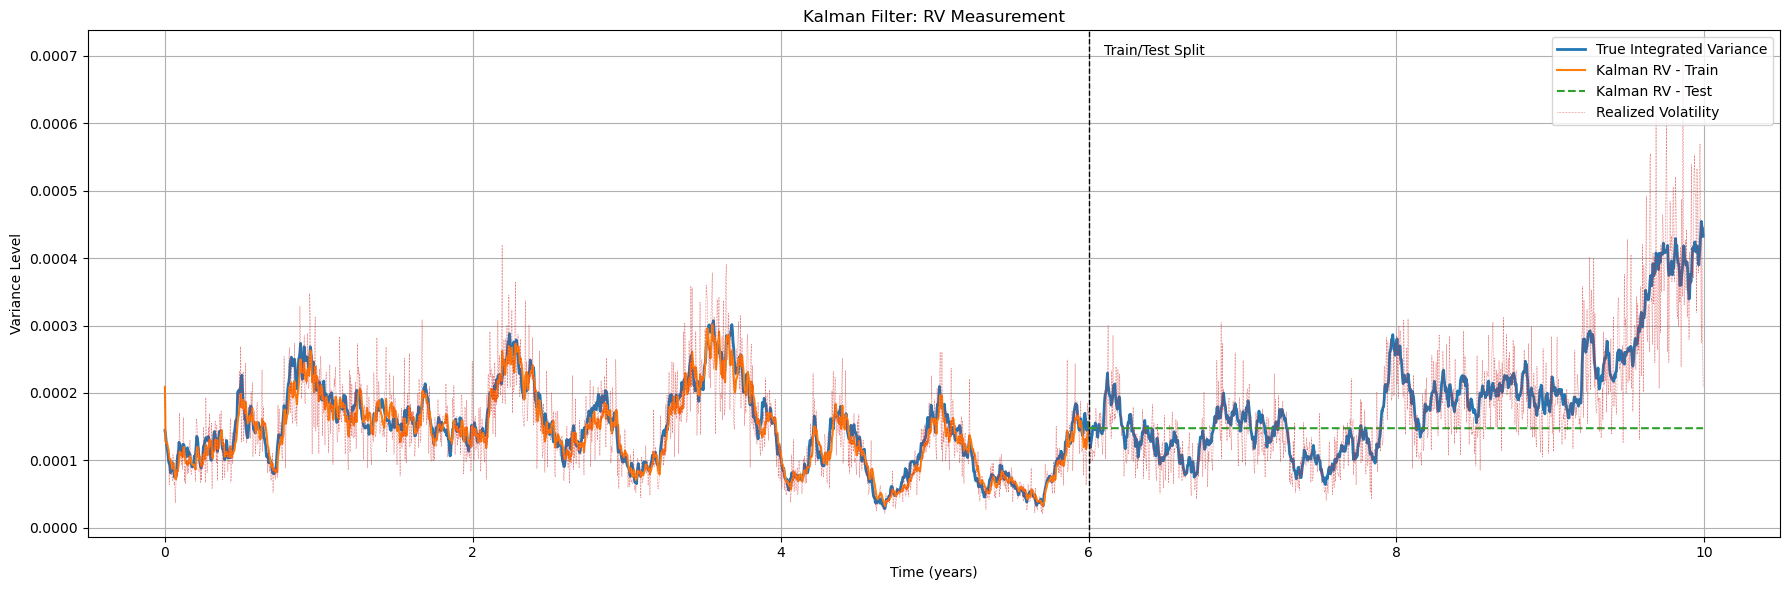

In-Sample RMSE (RV Measurement): 0.000016
Out-of-Sample RMSE (RV Measurement): 0.000094


(1.6310026399041452e-05, 9.384221679973526e-05)

In [65]:
Utility.plot_filter_result(
    plot_index=2,
    titles=titles_all,
    labels=labels_all,
    train_filtered_list=train_all,
    test_filtered_list=test_all,
    daily_true_V=daily_true_V,
    daily_RV=daily_RV,
    daily_returns=daily_returns,
    split_index=split_index,
    burnin=0
)

In [68]:
# Print RMSEs
for k, v in rmse_is_dict.items():
    print(f"In-Sample RMSE ({k}): {v:.6f}")

In-Sample RMSE (BOTH Measurements): 0.000026
In-Sample RMSE (RETURNS Measurement): 0.000043
In-Sample RMSE (RV Measurement): 0.000019


In [69]:
# Print RMSEs
for k, v in rmse_oos_dict.items():
    print(f"Out-of-Sample RMSE ({k}): {v:.6f}")

Out-of-Sample RMSE (BOTH Measurements): 0.000024
Out-of-Sample RMSE (RETURNS Measurement): 0.000107
Out-of-Sample RMSE (RV Measurement): 0.000034


In [70]:
pf_heston = pf.PFHeston(np.log(S_daily), N=15000, is_log=True)

param_bounds = [
    (0.05, 0.5),   # mu
    (1, 3),        # kappa
    (0.05, 0.2),   # theta
    (0.01, 0.8),  # xi
    (-1, 0),       # rho
    V0            # v0
]

V_pf, param_steps = pf_heston.filter(param_bounds, predict_obs=False)
V_pf = V_pf / 252

resampling since: 1511.233396988465
resampling since: 2374.7145590976497
resampling since: 1687.7351095474526
resampling since: 829.1718213373316
resampling since: 3062.397356905797
resampling since: 2575.114956648601
resampling since: 468.34845809644617
resampling since: 94.45828266136635
resampling since: 931.3918359856331
resampling since: 1943.6094009056455
resampling since: 2966.678539228874
resampling since: 1748.4672666923213
resampling since: 176.47500026491082
resampling since: 3323.340522015717
resampling since: 3322.767969686327
resampling since: 1186.367428622764
resampling since: 1838.4882210201847
resampling since: 3357.7381090916188
resampling since: 3331.167581794232
resampling since: 1596.492983887279
resampling since: 30.46239750368404
resampling since: 627.8575501120978
resampling since: 3314.7554836112
resampling since: 2503.9033057506417
resampling since: 3169.1443971139042
resampling since: 1249.84692882191
resampling since: 1917.6933968227781
resampling since: 24

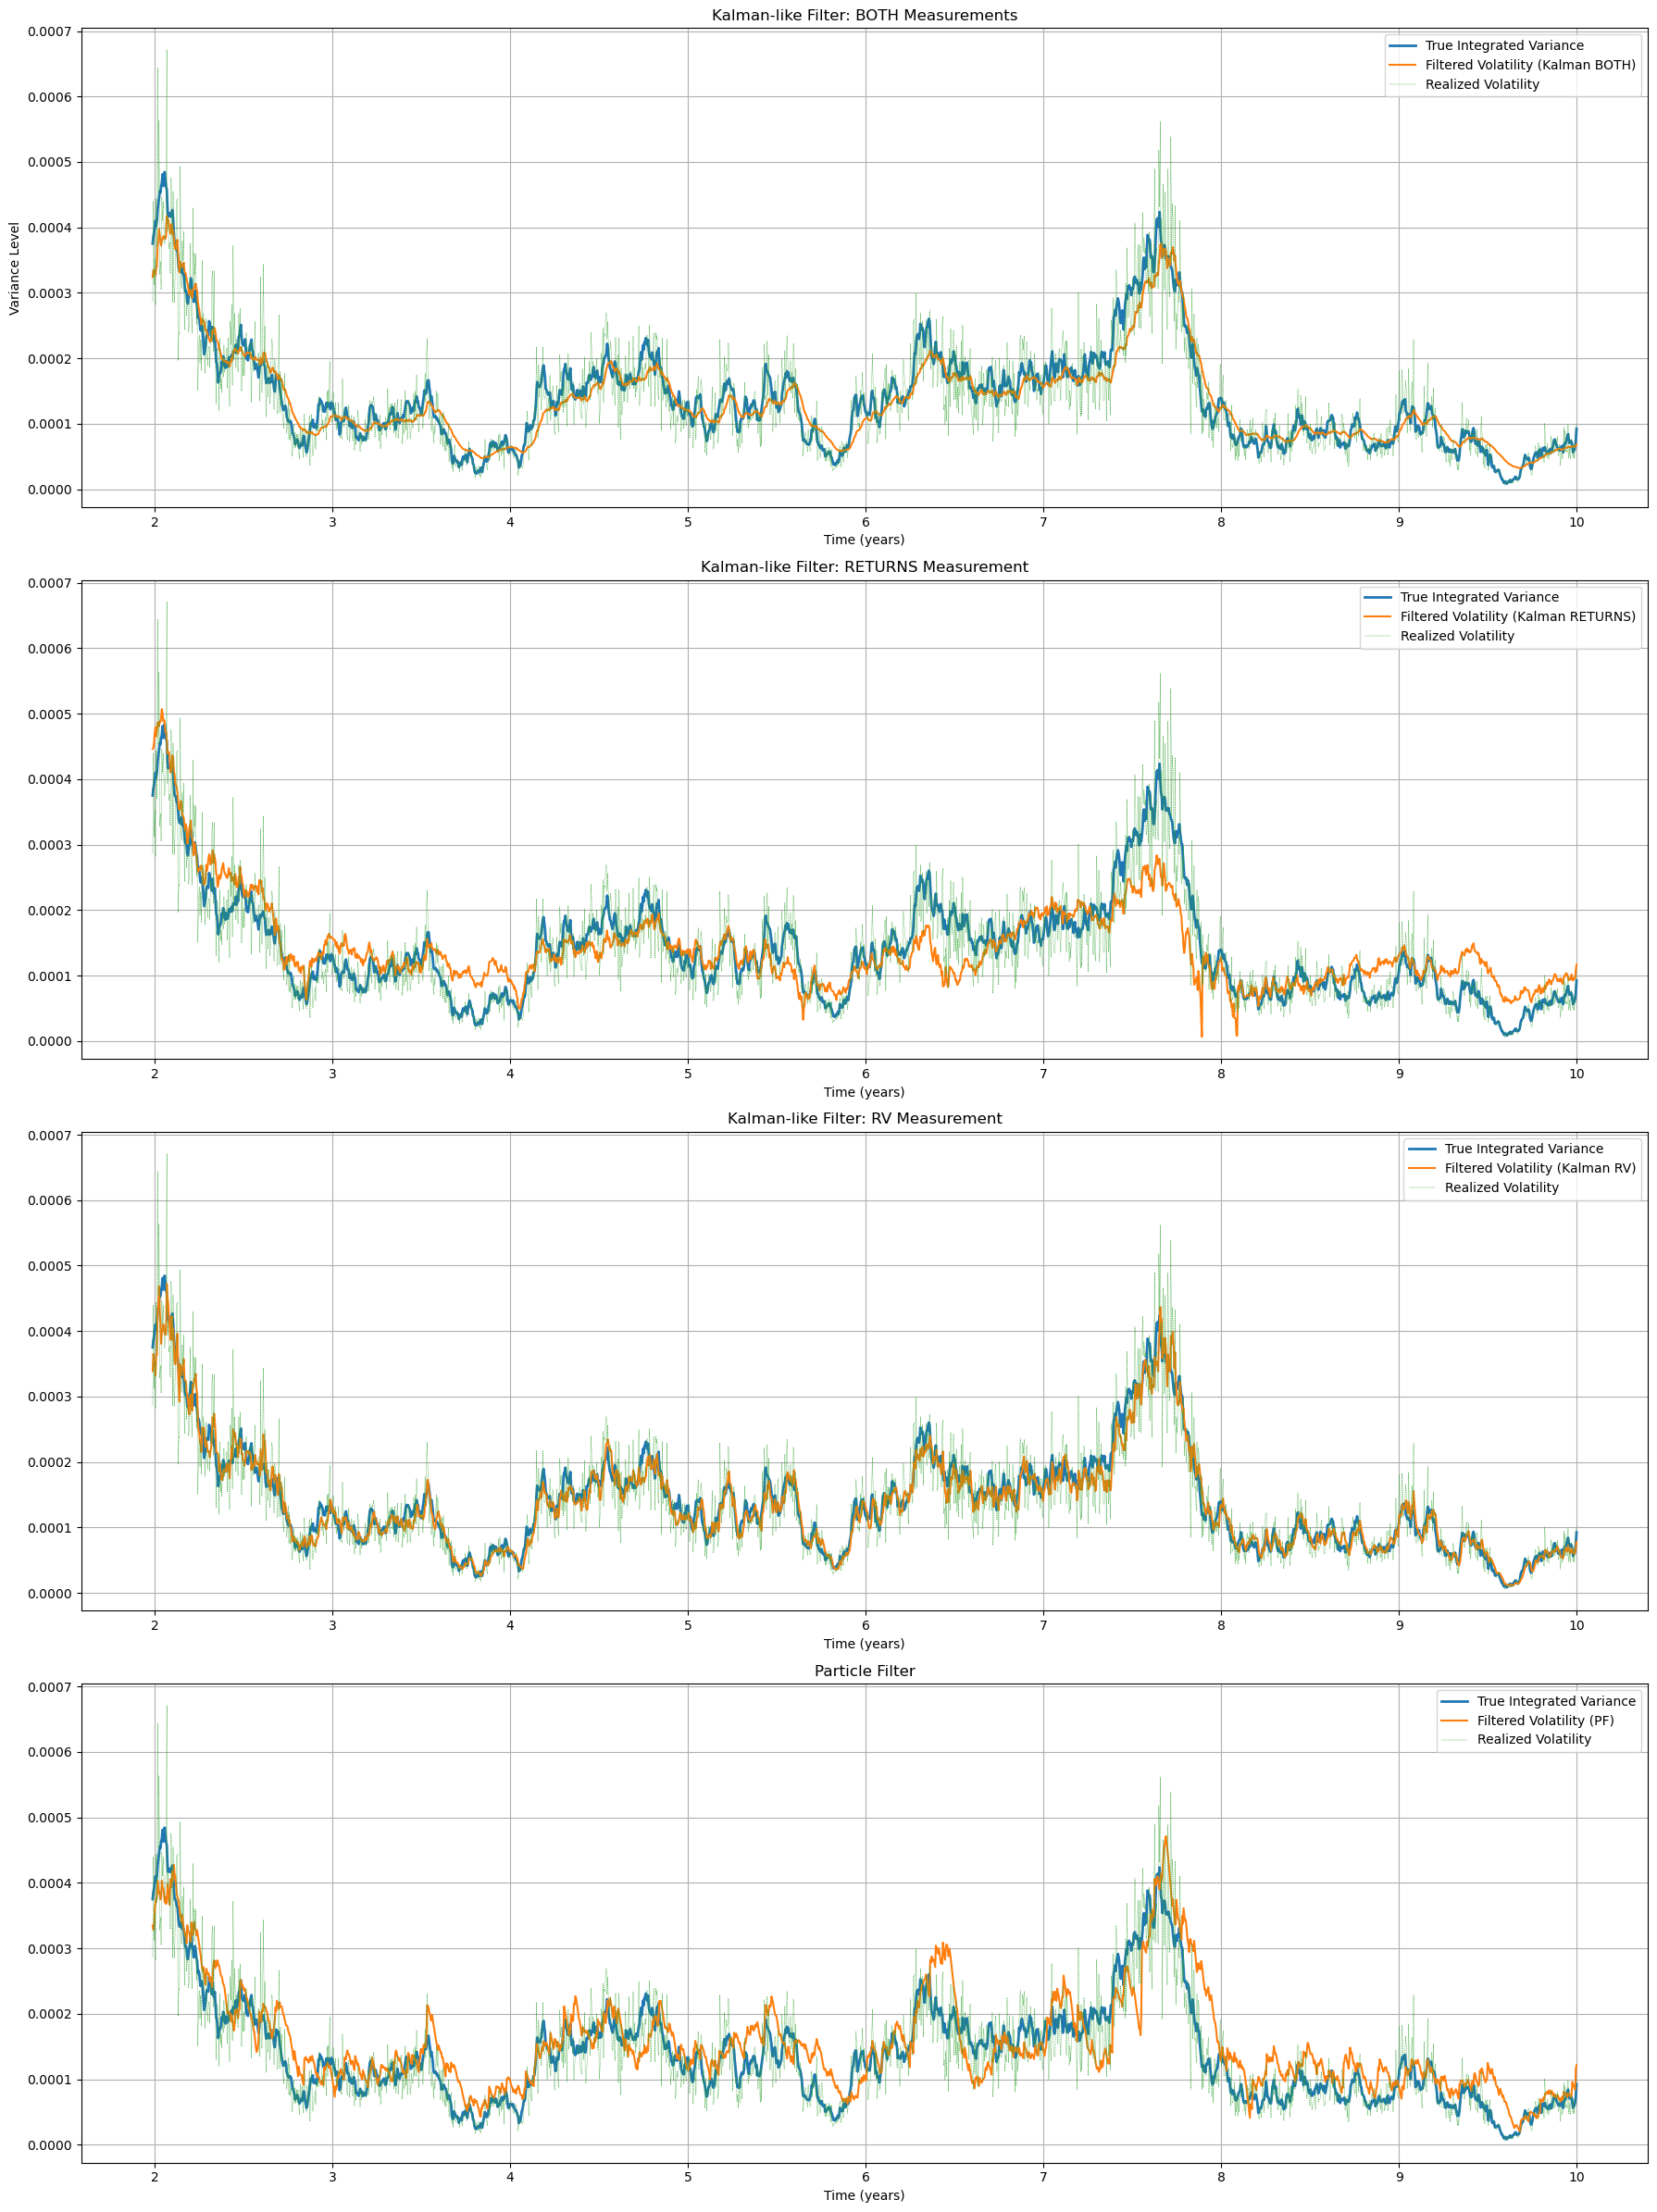

RMSE (PF - Filtered vs True): 0.000043
RMSE (RETURNS - Filtered vs True): 0.000041
RMSE (BOTH - Filtered vs True): 0.000025
RMSE (RV - Filtered vs True): 0.000017

--- Model Summary: BOTH ---

Heston Kalman Filter Summary
Measurement Type: both
Time Interval (dt): 1
Initial Variance (V0): 0.010000
Initial Covariance (P0): 0.100000

Fitted Parameters:
--------------------------------------------------
kappa: 0.005585
theta: 0.000103
xi: 0.000641
mu: 0.000654
sigma: 0.000026

Negative Log-Likelihood: -22761.345969
Convergence: True

AIC: -45512.691938
BIC: -45483.533851

--- Model Summary: RETURNS ---

Heston Kalman Filter Summary
Measurement Type: returns
Time Interval (dt): 1
Initial Variance (V0): 0.010000
Initial Covariance (P0): 0.100000

Fitted Parameters:
--------------------------------------------------
kappa: 0.007791
theta: 0.000094
xi: 0.004125
mu: 0.001036

Negative Log-Likelihood: -5479.094083
Convergence: False
Message: ABNORMAL_TERMINATION_IN_LNSRCH

AIC: -10950.188165
BI

In [71]:
burnin = 500

# Create 4 subplots
fig, axes = plt.subplots(4, 1, figsize=(18, 24))

# 1: BOTH measurements
axes[0].plot(time_daily[burnin:], daily_true_V[burnin:], label="True Integrated Variance", lw=2)
axes[0].plot(time_daily[burnin:], V_filt_both[burnin:], label="Filtered Volatility (Kalman BOTH)", lw=1.5)
# axes[0].plot(time_daily[burnin:], hkf_both.get_predicted_variance()[burnin:], label="Filtered Volatility (Kalman BOTH)", lw=1.5)

axes[0].plot(time_daily[burnin:], daily_RV[burnin:], label="Realized Volatility", lw=0.3, linestyle="--")
axes[0].set_title("Kalman-like Filter: BOTH Measurements")
axes[0].set_xlabel("Time (years)")
axes[0].set_ylabel("Variance Level")
axes[0].legend(loc="upper right")
axes[0].grid(True)

# 2: RETURNS measurement
axes[1].plot(time_daily[burnin:], daily_true_V[burnin:], label="True Integrated Variance", lw=2)
axes[1].plot(time_daily[burnin:], V_filt_returns[burnin:], label="Filtered Volatility (Kalman RETURNS)", lw=1.5)
# axes[1].plot(time_daily[burnin:], hkf_returns.get_predicted_variance()[burnin:], label="Filtered Volatility (Kalman RETURNS)", lw=1.5)

axes[1].plot(time_daily[burnin:], daily_RV[burnin:], label="Realized Volatility", lw=0.3, linestyle="--")
axes[1].set_title("Kalman-like Filter: RETURNS Measurement")
axes[1].set_xlabel("Time (years)")
axes[1].legend(loc="upper right")
axes[1].grid(True)

# 3: RV measurement
axes[2].plot(time_daily[burnin:], daily_true_V[burnin:], label="True Integrated Variance", lw=2)
axes[2].plot(time_daily[burnin:], V_filt_rv[burnin:], label="Filtered Volatility (Kalman RV)", lw=1.5)
# axes[2].plot(time_daily[burnin:], hkf_rv.get_predicted_variance()[burnin:], label="Filtered Volatility (Kalman RV)", lw=1.5)

axes[2].plot(time_daily[burnin:], daily_RV[burnin:], label="Realized Volatility", lw=0.3, linestyle="--")
axes[2].set_title("Kalman-like Filter: RV Measurement")
axes[2].set_xlabel("Time (years)")
axes[2].legend(loc="upper right")
axes[2].grid(True)

# 4: Particle Filter
axes[3].plot(time_daily[burnin:], daily_true_V[burnin:], label="True Integrated Variance", lw=2)
axes[3].plot(time_daily[burnin:], V_pf[burnin:], label="Filtered Volatility (PF)", lw=1.5)
axes[3].plot(time_daily[burnin:], daily_RV[burnin:], label="Realized Volatility", lw=0.3, linestyle="--")
axes[3].set_title("Particle Filter")
axes[3].set_xlabel("Time (years)")
axes[3].legend(loc="upper right")
axes[3].grid(True)

plt.tight_layout()
plt.show()

# Compute RMSE (Post Burnin)
true_post = daily_true_V[burnin:]
rmse_both = np.sqrt(np.mean((true_post - V_filt_both[burnin:]) ** 2))
rmse_returns = np.sqrt(np.mean((true_post - V_filt_returns[burnin:]) ** 2))
rmse_rv = np.sqrt(np.mean((true_post - V_filt_rv[burnin:]) ** 2))
rmse_pf = np.sqrt(np.mean((true_post - V_pf[burnin:]) ** 2))

print(f"RMSE (PF - Filtered vs True): {rmse_pf:.6f}")
print(f"RMSE (RETURNS - Filtered vs True): {rmse_returns:.6f}")
print(f"RMSE (BOTH - Filtered vs True): {rmse_both:.6f}")
print(f"RMSE (RV - Filtered vs True): {rmse_rv:.6f}")

# Print Model Summaries for Each Measurement Type
print("\n--- Model Summary: BOTH ---")
hkf_both.summary()

print("\n--- Model Summary: RETURNS ---")
hkf_returns.summary()

print("\n--- Model Summary: RV ---")
hkf_rv.summary()


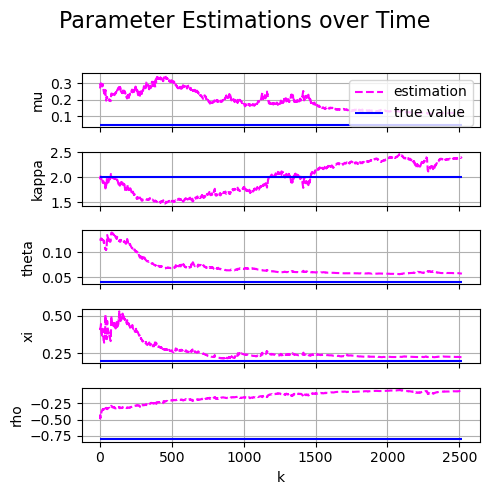

In [38]:
param_names = ['mu', 'kappa', 'theta', 'xi', 'rho']

fig, axs = plt.subplots(5, 1, figsize=(5, 5), sharex=True)
fig.suptitle('Parameter Estimations over Time', fontsize=16)

# Plot each parameter
for i in range(5):
    axs[i].plot(param_steps[i], linestyle='--', color='magenta', label='estimation')
    axs[i].hlines(params[param_names[i]], 0, param_steps.shape[1]-1, colors='blue', label='true value')
    axs[i].set_ylabel(param_names[i])
    axs[i].grid(True)

# Set common x-axis label
axs[-1].set_xlabel('k')

# Only add one legend (avoid repeated)
axs[0].legend(loc='upper right')

plt.tight_layout(rect=[0, 0, 1, 0.96])  # leave space for suptitle
plt.show()

In [13]:
np.zeros((1,2))

array([[0., 0.]])

In [ ]:
param_bounds = [
    (0.05, 0.5),   # mu
    (1, 3),        # kappa
    (0.05, 0.2),   # theta
    (0.01, 0.8),  # xi
    (-1, 0),       # rho
    V0             # v0
]